## Testing on unseen text data.

The goal of this notebook is to determine the performance of different embedding and algorithm on unseen text data

###  load the unseen text data

In [1]:
import pandas as pd

test_data = pd.read_csv("../clean_data/Cleaned_test_text_with_pii_\
2018_12_31_05_35_46_815414.csv")
train_data = pd.read_csv("../clean_data/Cleaned_train_text_with_pii_2018_12_29_07_26_56_266227.csv")

In [2]:
test_data.head()

,Text,Labels,PII,Cleaned_text,Target
0,Wife marriage cup 7416 Smith Forks before pict...,Address,7416 Smith Forks,wife marriage cup 7416 smith forks before pict...,1
1,However send which. Suite 244 Nice market acce...,Address,Suite 244,however send which suite 244 nice market accep...,1
2,0497 Kemp Lane Amount tough and fire until. Is...,Address,0497 Kemp Lane,0497 kemp lane amount tough and fire until iss...,1
3,Model north receive nature effort 58162 France...,Address,"58162 Frances Shoals Conniemouth, OH 71686",model north receive nature effort 58162 france...,1
4,Child already drive could. Begin such down cel...,Address,538 Gina Circles,child already drive could begin such down cell...,1


In [3]:
test_data['Labels'].value_counts()

Phone_number        10000
Plates              10000
None                10000
Email               10000
SSN                 10000
Name                10000
Address             10000
CreditCardNumber    10000
Name: Labels, dtype: int64

### Accomplish entire the training process with a simple Pipeline 

In [5]:
import re
def clean_text(text):
    # replace  . and a space with only a space, then amke all words lower case.
    text = text.replace(". "," ").replace(",","").lower()
    # get rid of the . at the end of each line. 
    cleaned_text = re.sub("\.$","",text)
    
    return cleaned_text
 


class text_clean:
    """
    A class to help with cleaning text data. 
    """
    def fit(self, X, y):
        return self
    def transform(self, X):
        assert isinstance(X,pd.Series), "The input data should be pandas Series."
        X = X.apply(clean_text)
        
        
        return X
    # This will return the entire dataframe with changed columns. 

In [6]:
from tqdm import tqdm
import numpy as np
from gensim.models import Word2Vec
from sklearn.externals import joblib



def _find_part_pii(text, model, sep = " "):
    tokenized_text = text.split(sep)
    
    part_pii = model.wv.doesnt_match(tokenized_text)
    
    return part_pii    



def _get_word2vec_matrix(pii_list, model):
    # set the matrix dimensions
    column_num = model.trainables.layer1_size
    row_num = len(pii_list)
    # initialized the matrix
    pii2vec_mat = np.zeros((row_num, column_num))
    # iterate through the pii_list and assign the vectors to matrix.
    for index, ith_pii in enumerate(tqdm(pii_list)):
        pii2vec_mat[index,:] = model.wv[ith_pii]
    
    return pii2vec_mat



class word2vec_embed:
    """
    A class to convert words/docs to vectors by applying word2vec 
    algorithm for training a classifier. 
    Also used for predicting new unseen text by assigning the model variable. 
    
    This class will allow continued training on the pre-trained model by assigning
    the model to the model option in class initialization.  
    
    After training the model, it will dump the word2vec model to the path assigned to 
    dump_file option to allow training speed-up by avoiding repeated training in fit method. 
    
    If the following training, it will use the dumped word2vec model if the use_dump_file option 
    is set to True. The default option for use_dump_file is True. 
    """
    def __init__(self, size = 100, window=5,min_count = 1, workers = 1, \
                 epochs = 5, model = None, dump_file = False, use_dump_file = True):
        self.size = size
        self.window = window
        self.min_count = min_count 
        self.epochs =  epochs 
        # this is set to 1 to voids problem with multi-core training. 
        self.workers = workers 
        
        self.model = model
        self.dump_file = dump_file
        self.use_dump_file = use_dump_file
        self.model = model
        if model is not None:
            self.size = model.trainables.layer1_size
            self.window = model.window
            self.min_count = model.min_count
            
    def _build_vocab_and_train(self,tokenized_sentences):
        # build vocab and train the word2vec model. 
        model = Word2Vec(size = self.size, window = self.window\
                        ,min_count = self.min_count, workers = self.workers )
        

        model.build_vocab(tokenized_sentences)
            
        
        model.train(tokenized_sentences, total_examples = len(tokenized_sentences),\
                    epochs = self.epochs)
        # assign the trained model to self.model and return self.
        self.model = model
        
        return model
            
        
    def fit(self, X, y):
        assert isinstance(X,pd.Series), "The input data should be pandas \
        Series for word2vec."
        
        # tokenized the sentences 
        tokenized_sentences = [sentence.split(" ") for sentence in X]
        
        # allow pre-trained models 
        if self.model is not None:
            self.model = model
            
            return self
        
        elif self.use_dump_file and isinstance(self.dump_file, str):
            try:
                model = Word2Vec.load(self.use_dump_file)
            except:
                model = self._build_vocab_and_train(tokenized_sentences)   
            
        else:
            model = self._build_vocab_and_train(tokenized_sentences)
            
        if isinstance(self.dump_file,str):
            model.save(self.dump_file)
            
        
        return self
    
    def transform(self, X):
        # update the embedding with new sentences. 
        model_updated = self.model
        tokenized_new_sentences = [new_sentence.split(" ") for new_sentence in X]
        model_updated.build_vocab(tokenized_new_sentences, update = True)
        model_updated.train(tokenized_new_sentences,\
                                  total_examples = len(tokenized_new_sentences)\
                                  , epochs = self.epochs)
        # extract the PII 
        extracted_pii_list = [_find_part_pii(text, model = model_updated)\
                    for text in tqdm(X) ]
        
        # convert the extracted pii text into vectors.
        pii_matrix = _get_word2vec_matrix(pii_list = extracted_pii_list,\
                                          model = model_updated)
        return pii_matrix 
                                          

In [7]:
class doc2vec_embed:
    pass

In [15]:
from gensim.models import FastText

class fasttext_embed:
    """
    A class to convert words/docs to vectors by applying fasttext 
    algorithm for training a classifier. 
    """
    def __init__(self, size = 100, window=5,min_count = 1, workers = 1, \
                 epochs = 5, model = None, dump_file = False, use_dump_file = True):
        self.size = size
        self.window = window
        self.min_count = min_count 
        self.epochs =  epochs 
        # this is set to 1 to voids problem with multi-core training. 
        self.workers = workers 
        
        self.model = model
        self.dump_file = dump_file
        self.use_dump_file = use_dump_file
        self.model = model
        if model is not None:
            self.size = model.trainables.layer1_size
            self.window = model.window
            self.min_count = model.min_count
    def _build_vocab_and_train(self,tokenized_sentences):
        # build vocab and train the word2vec model. 
        model = FastText(size = self.size, window = self.window\
                        ,min_count = self.min_count, workers = self.workers )
        

        model.build_vocab(tokenized_sentences)
            
        
        model.train(tokenized_sentences, total_examples = len(tokenized_sentences),\
                    epochs = self.epochs)
        # assign the trained model to self.model and return self.
        self.model = model
        
        return model

    def fit(self, X, y):
        assert isinstance(X,pd.Series), "The input data should be pandas \
        Series for word2vec."
        
        # tokenized the sentences 
        tokenized_sentences = [sentence.split(" ") for sentence in X]
        
        # allow pre-trained models 
        if self.model is not None:
            self.model = model
            
            return self
        
        elif self.use_dump_file and isinstance(self.dump_file, str):
            try:
                model = FastText.load(self.use_dump_file)
            except:
                model = self._build_vocab_and_train(tokenized_sentences)   
            
        else:
            model = self._build_vocab_and_train(tokenized_sentences)
            
        if isinstance(self.dump_file,str):
            model.save(self.dump_file)
            
        
        return self
    
    def transform(self, X):
        # extract the PII 
        extracted_pii_list = [_find_part_pii(text, model = self.model)\
                    for text in tqdm(X) ]
        
        # convert the extracted pii text into vectors.
        pii_matrix = _get_word2vec_matrix(pii_list = extracted_pii_list,\
                                          model = model_updated)
        return pii_matrix 

In [9]:
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression
logit_clf = LogisticRegression(solver = "lbfgs", max_iter = 10000, class_weight={0:0.9,1:0.1})

## Pipeline for fasttext+logistic model

In [16]:
fasttext_pipe = Pipeline([('text_cleaning', text_clean()),
                 ("fasttext", fasttext_embed(size= 100, dump_file = "fasttext_100_pipe_dump.bin")),
                 ("logit",logit_clf)
                ])

In [17]:
%%time
fasttext_pipe.fit(train_data["Text"],train_data["Target"])

100%|██████████| 800000/800000 [00:03<00:00, 246029.80it/s]


Pipeline(memory=None,
     steps=[('text_cleaning', <__main__.text_clean object at 0x7ff120564978>), ('fasttext', <__main__.fasttext_embed object at 0x7ff120564c50>), ('logit', LogisticRegression(C=1.0, class_weight={0: 0.9, 1: 0.1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [18]:
%%time 
binary_pred = fasttext_pipe.predict(test_data["Text"])
binary_true = test_data["Target"]

from sklearn.metrics import classification_report

print(classification_report(y_true = binary_true, y_pred = binary_pred))

100%|██████████| 80000/80000 [00:00<00:00, 232284.71it/s]


              precision    recall  f1-score   support

           0       0.14      0.01      0.02     10000
           1       0.88      0.99      0.93     70000

   micro avg       0.87      0.87      0.87     80000
   macro avg       0.51      0.50      0.48     80000
weighted avg       0.78      0.87      0.82     80000

CPU times: user 1min 50s, sys: 1.48 s, total: 1min 51s
Wall time: 1min 51s


Text(51,0.5,'True values')

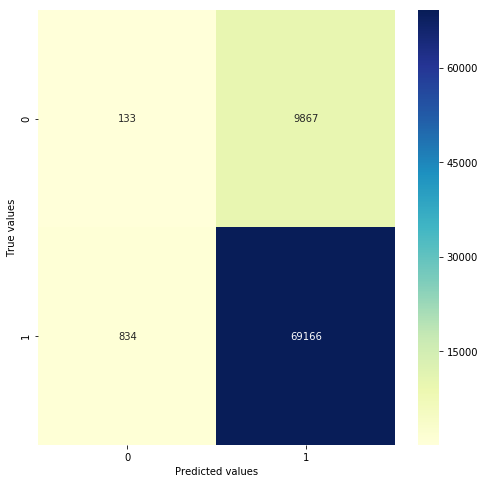

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize= (8,8))
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d",cmap="YlGnBu")
plt.xlabel("Predicted values")
plt.ylabel("True values")

## Pipeline for  word2vec+Logistic model 

In [ ]:
word2vec_pipe = Pipeline([('text_cleaning', text_clean()),
                 ("word2vec", word2vec_embed(size= 100, dump_file = "word2vec_100_pipe_dump.bin")),
                 ("logit",logit_clf)
                ])

%%time
word2vec_pipe.fit(train_data["Text"],train_data["Target"])

In [12]:
%%time 
binary_pred = word2vec_pipe.predict(test_data["Text"])
binary_true = test_data["Target"]

100%|██████████| 80000/80000 [00:00<00:00, 221695.92it/s]


CPU times: user 25.8 s, sys: 438 ms, total: 26.2 s
Wall time: 27.2 s


In [13]:
%%time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize= (8,8))
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d",cmap="YlGnBu")
plt.xlabel("Predicted values")
plt.ylabel("True values")

CPU times: user 335 ms, sys: 92.9 ms, total: 428 ms
Wall time: 319 ms


In [14]:
%%time
from sklearn.metrics import classification_report

print(classification_report(y_true = binary_true, y_pred = binary_pred))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76     10000
           1       1.00      0.91      0.95     70000

   micro avg       0.92      0.92      0.92     80000
   macro avg       0.81      0.96      0.86     80000
weighted avg       0.95      0.92      0.93     80000

CPU times: user 67.1 ms, sys: 40.1 ms, total: 107 ms
Wall time: 55.4 ms


The performance was quite good for a first relase. 